# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idatas = {
    d: az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, d, "idata"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d)) and "whisker" in d
}
idatas["whisker-ind"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [3]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")

# Plot measurements

In [4]:
whisker_data = load_prepared_data("../data/prepared/whisker.json")

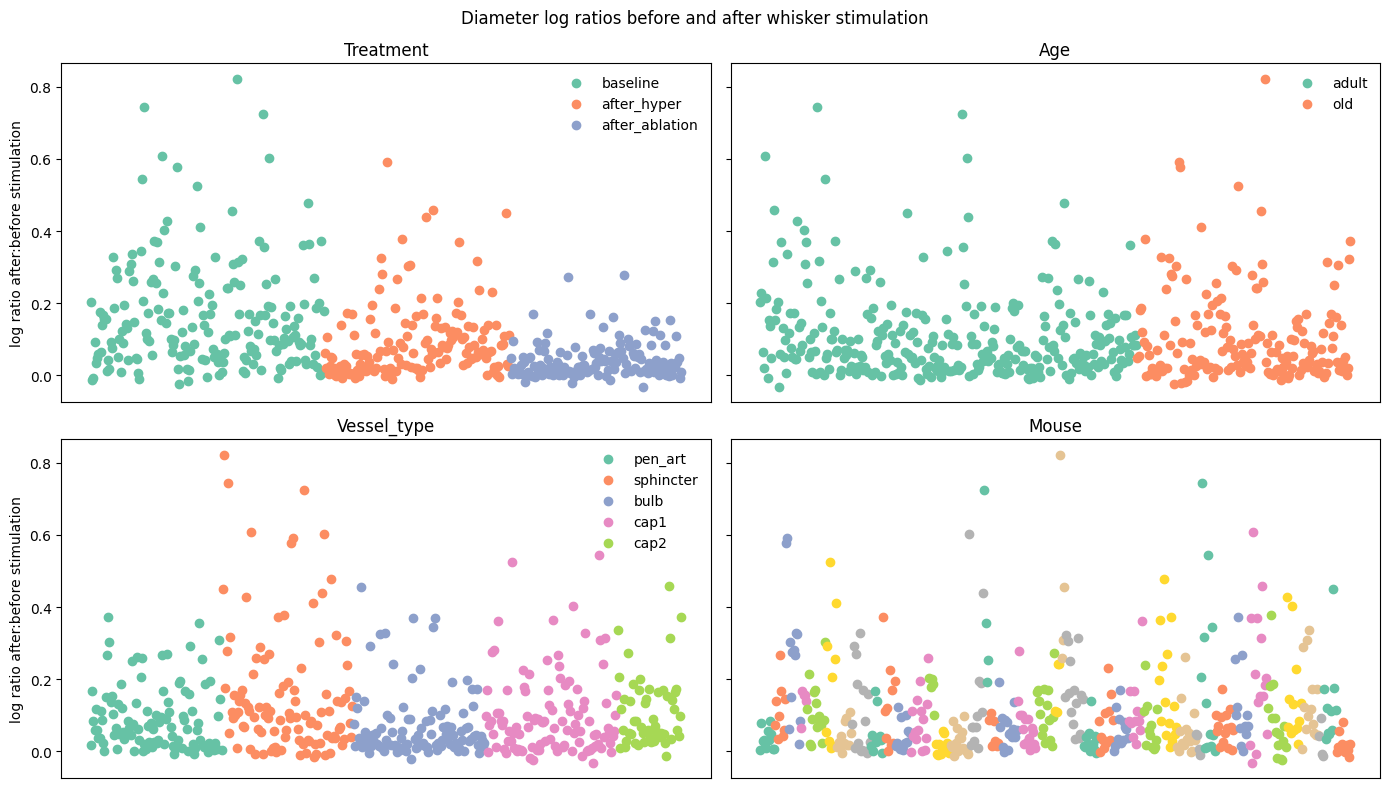

In [5]:
def plot_raw_data(ax, obs, **scatter_kwargs):
    x = np.linspace(*ax.get_xlim(), len(obs))
    ax.set_xticks([]);
    return ax.scatter(x, obs, **scatter_kwargs);

def get_colors(col, cmap):
    
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm)
    return {cat: scalarMap.to_rgba(i) for i, cat in enumerate(col.cat.categories)}


def plot_raw_data_cat(ax, obs, catcol, cmap, weird_level=None, **scatter_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame({"obs": obs, "cat": catcol}).sort_values("cat").assign(x=np.linspace(*ax.get_xlim(), len(obs)))
    scts = []
    if "label" in scatter_kwargs.keys():
        user_provided_label = True
        label = scatter_kwargs["label"]
        del scatter_kwargs["label"]
    else:
        user_provided_label = False
    for i, cat in enumerate(catcol.cat.categories):
        color = colors[i % len(colors)]
        y = d.loc[catcol == cat, "obs"]
        xcat = d.loc[y.index, "x"]
        label = label if user_provided_label else cat
        scts.append(ax.scatter(xcat, y, label=label, color=color, **scatter_kwargs))
        if weird_level is not None:
            for i, yi in y.items():
                if yi > weird_level:
                    ax.text(xcat.loc[i], yi, "?")
    return scts
    
obs = whisker_data.measurements["diam_log_ratio"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = whisker_data.measurements[col]
    plot_raw_data_cat(ax, obs, catcol, cmap=cmap, weird_level=1.0)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("log ratio after:before stimulation");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("Diameter log ratios before and after whisker stimulation");
f.tight_layout()

f.savefig(os.path.join(PLOTS_DIR, "whisker-measurements-faceted.png"), bbox_inches="tight")

In [6]:
whisker_data.measurements.sort_values("diam_log_ratio", ascending=False).head(10)

,age,mouse,vessel_type,treatment,pressure_d,diam_before,diam_after,diam_change,diam_log_ratio,diam_rel_change
1398,old,170321,sphincter,baseline,45.931747,2.883007,6.561974,3.678967,0.822458,1.276087
257,adult,220920,sphincter,baseline,57.342675,1.292246,2.716551,1.424305,0.742981,1.102193
790,adult,130520,sphincter,baseline,39.711475,2.875097,5.935412,3.060316,0.724850,1.064422
65,adult,260520,sphincter,baseline,56.003344,2.743920,5.040000,2.296080,0.608019,0.836788
293,adult,121020,sphincter,baseline,57.342675,2.027385,3.707182,1.679797,0.603525,0.828553
1090,old,20920,sphincter,after_hyper,54.881456,3.505669,6.338039,2.832369,0.592188,0.807940
1078,old,20920,sphincter,baseline,59.925212,5.798635,10.344819,4.546184,0.578863,0.784009
259,adult,220920,cap1,baseline,57.492351,1.877116,3.232112,1.354997,0.543399,0.721850
984,old,50520,cap1,baseline,43.182158,2.444732,4.134000,1.689268,0.525310,0.690983
822,adult,210521,sphincter,baseline,59.824516,5.636729,9.092732,3.456002,0.478171,0.613122


## Comparing in and out of sample log likelihoods

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected posterior log predictive density for each inference.

It then calculates the average posterior in and out of sample log likelihoods.

In [7]:
idatas_to_compare = {k: v for k, v in idatas.items() if "whisker" in k and "log_likelihood" in v.groups()}
if len(idatas_to_compare.keys()) == 1:
    validation = az.loo(next(iter(idatas_to_compare.values())))
elif len(idatas_to_compare.keys()) > 1:
    validation = az.compare(idatas_to_compare)
display(validation)

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
whisker-ind,0,360.227443,180.810976,0.000000,0.835228,37.635125,0.000000,False,log
whisker-flat,1,194.102916,803.910222,166.124527,0.164772,32.764896,24.134694,False,log


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


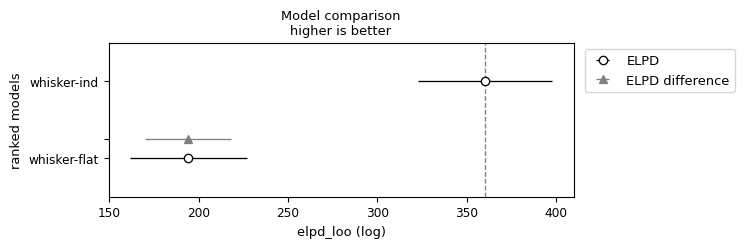

In [8]:
az.plot_compare(validation);

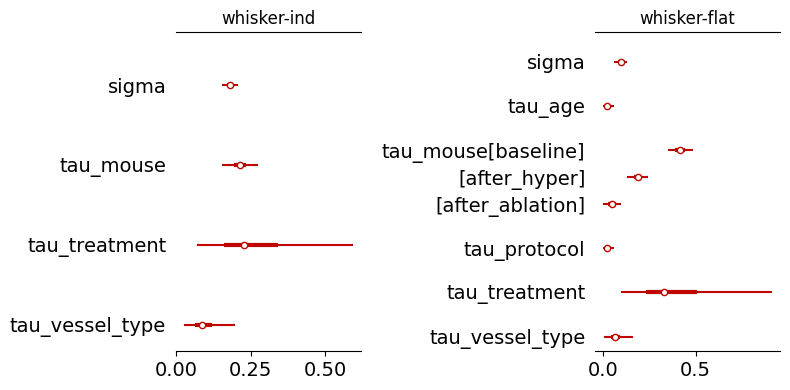

In [9]:
f, axes = plt.subplots(1, 2, figsize=[8, 4])
for (name, idata), ax in zip(idatas.items(), axes):
    az.plot_forest(
        idata,
        var_names=["sigma", "tau"],
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
plt.tight_layout()

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(


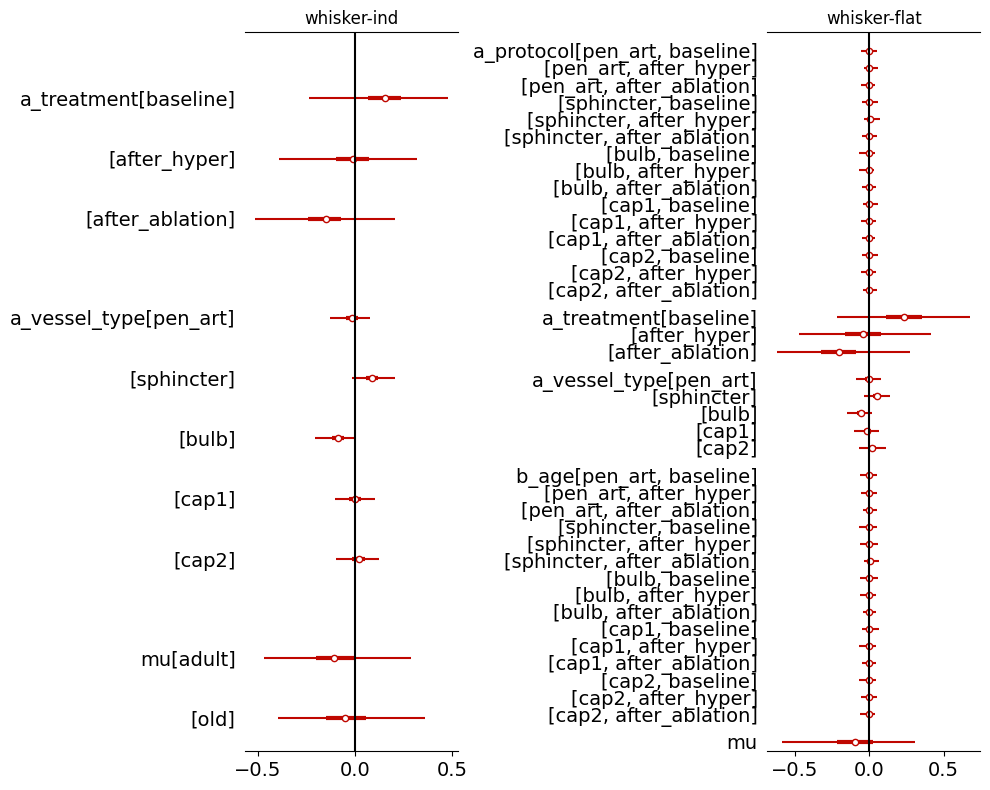

In [10]:
f, axes = plt.subplots(1, 2, figsize=[10, 8])
for (name, idata), ax in zip(idatas.items(), axes):
    az.plot_forest(
        idata,
        var_names=["~a_mouse", "~_z", "~tau", "~nu", "~sigma", "~a_vtm"], 
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
    ax.axvline(0, color="black")
plt.tight_layout()

In [11]:
idatas["whisker-flat"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

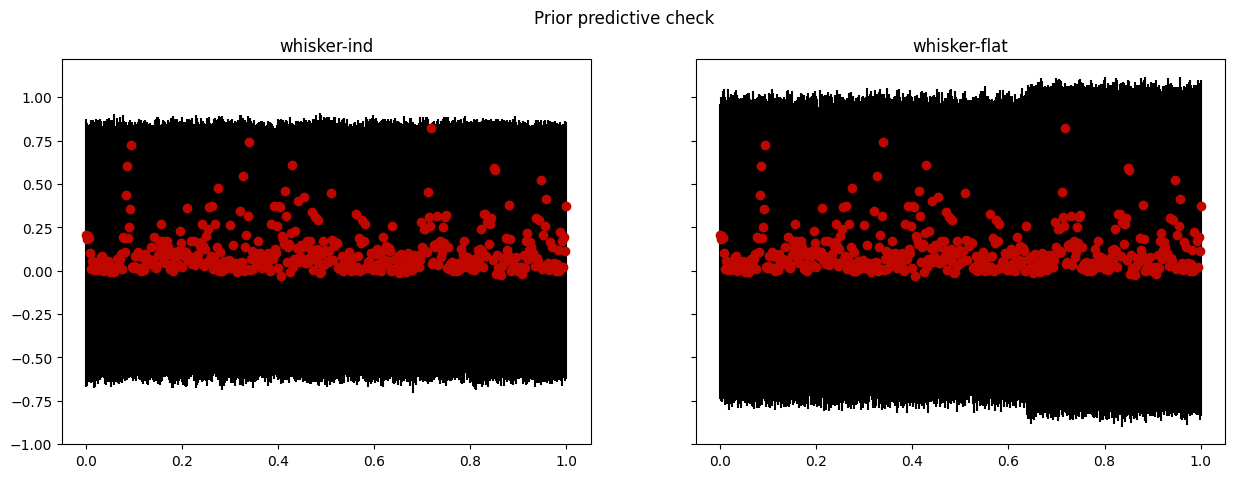

In [12]:
f, axes = plt.subplots(1, len(idatas.values()), figsize=[15, 5], sharey=True)
f.suptitle("Prior predictive check")

for ax, (name, idata) in zip(axes, idatas.items()):
    yobs = xr.DataArray(
        idata.observed_data["y"].values, 
        coords={"observation": idata.prior_predictive.coords["observation"]}
    )
    yrep = idata.prior_predictive["yrep"]
    qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
    x = np.linspace(*ax.get_xlim(), len(yobs))
    ax.scatter(x, yobs);
    ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1);
    ax.set_title(name);
f.savefig(os.path.join(PLOTS_DIR, "whisker-prior-check.png"), bbox_inches="tight")

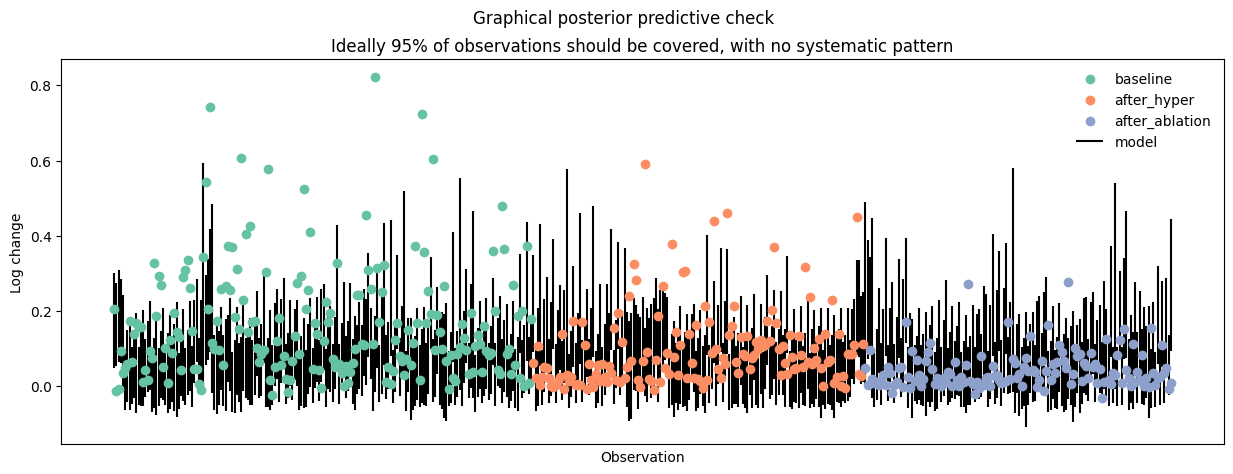

In [19]:
f, ax = plt.subplots(figsize=[15, 5])

yobs = pd.Series(xr.DataArray(
    idatas["whisker-ind"].observed_data["y"].values, 
    coords={"observation": idatas["whisker-flat"].posterior_predictive.coords["observation"]}
).values, index=whisker_data.measurements.index)
yrep = idatas["whisker-flat"].posterior_predictive["yrep"]
qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
x = np.linspace(*ax.get_xlim(), len(yobs))
plot_raw_data_cat(ax, yobs, whisker_data.measurements["treatment"], cmap=cmap)
ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1, label="model");
ax.set_xticks([])
ax.legend(frameon=False);
ax.set(
    title="Ideally 95% of observations should be covered, with no systematic pattern",
    ylabel="Log change",
    xlabel="Observation"
);
f.suptitle("Graphical posterior predictive check");
f.savefig(os.path.join(PLOTS_DIR, "whisker-posterior-check.png"), bbox_inches="tight")

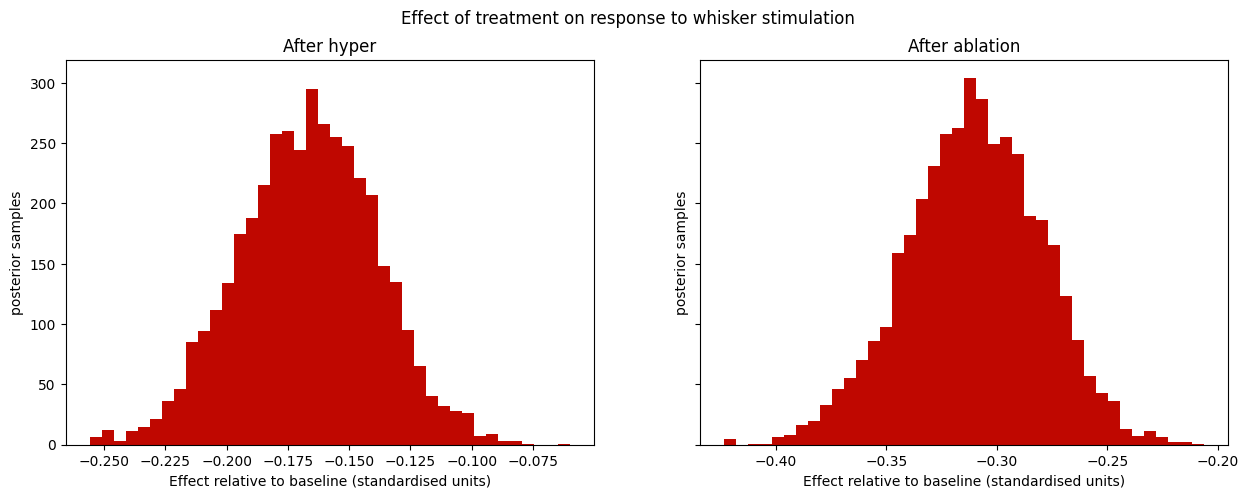

In [14]:
diff = idatas["whisker-ind"].posterior["a_treatment"] - idatas["whisker-ind"].posterior["a_treatment"].sel(treatment="baseline")

f, axes = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
f.suptitle("Effect of treatment on response to whisker stimulation")
for treatment, ax in zip(["after_hyper", "after_ablation"], axes):
    ax.set(
        title=f"{treatment.capitalize().replace('_', ' ')}",
        ylabel="posterior samples",
        xlabel="Effect relative to baseline (standardised units)"
    )
    ax.hist(diff.sel(treatment=treatment).values.flatten(), bins=40)
f.savefig(os.path.join(PLOTS_DIR, "whisker-treatment-effects.png"), bbox_inches="tight")

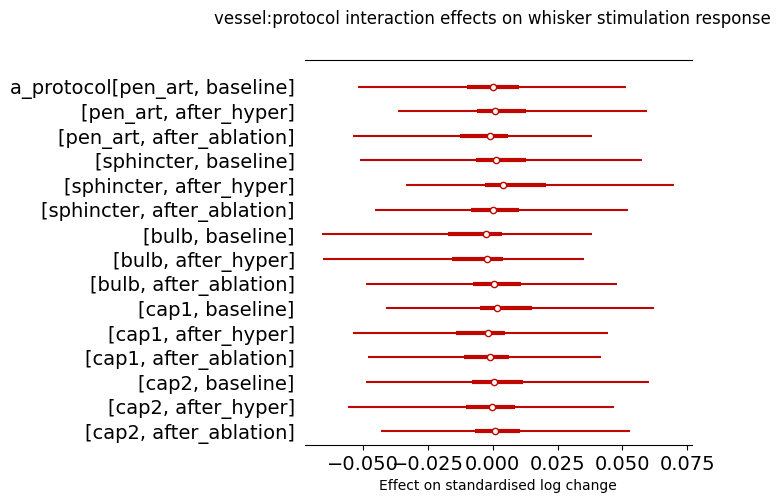

In [15]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("vessel:protocol interaction effects on whisker stimulation response")
az.plot_forest(
        idatas["whisker-flat"],
        var_names="a_protocol",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-protocol-effects.png"), bbox_inches="tight")

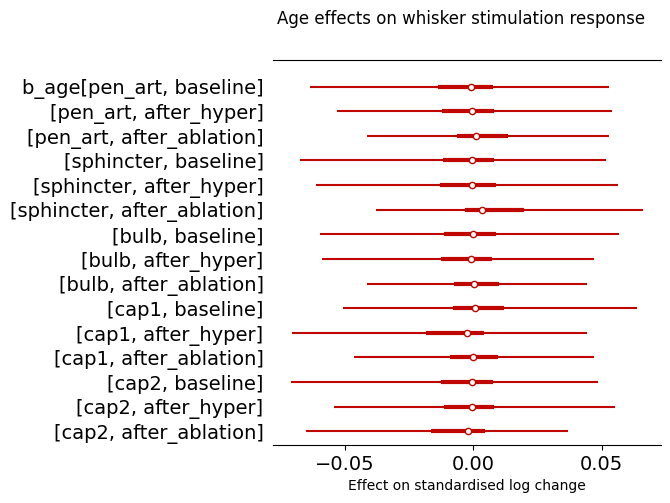

In [16]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Age effects on whisker stimulation response")
az.plot_forest(
        idatas["whisker-flat"],
        var_names="b_age",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-age-effects.png"), bbox_inches="tight")

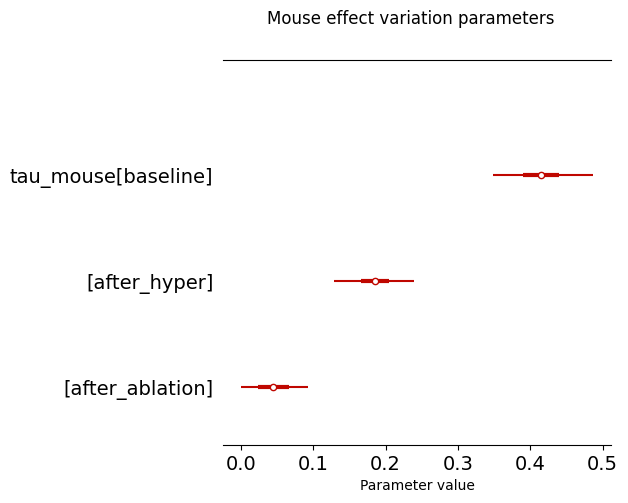

In [17]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Mouse effect variation parameters")
az.plot_forest(
        idatas["whisker-flat"],
        var_names="tau_mouse",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-tau-mouse.png"), bbox_inches="tight")

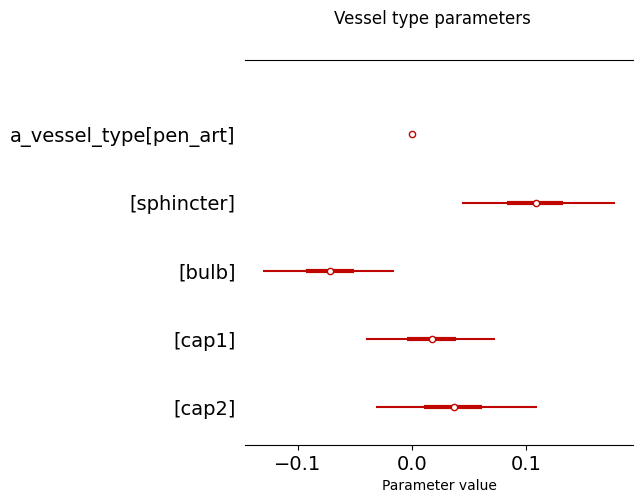

In [26]:
diff = idatas["whisker-ind"].posterior["a_vessel_type"] - idatas["whisker-ind"].posterior["a_vessel_type"].sel(vessel_type="pen_art")

f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Vessel type parameters")
az.plot_forest(
        diff,
        var_names="a_vessel_type",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-vessel-type-effects.png"), bbox_inches="tight")

In [27]:
(diff.sel(vessel_type='sphincter').values.flatten() > 0).mean()

0.99825

In [28]:
(diff.sel(vessel_type='bulb').values.flatten() > 0).mean()

0.00875